In [32]:
from neuron import h
from neuron.units import mV, ms
h.load_file('stdrun.hoc')

import numpy as np
import random
import matplotlib.pyplot as plt

In [9]:
def gen_histories(sim_length = 10000, stim_interval = 10, num_histories = 1000):

    # Set up biophysical model
    axon = h.Section(name='axon')
    axon.insert(h.hh)

    # add a synapse
    syn = h.ExpSyn(axon(0))
    syn.tau = 1 * ms
    syn.e = 0 * mV
    syn_current = h.Vector().record(syn._ref_i)

    # add a stimulus
    stim = h.NetStim()
    stim.number = 9999999
    stim.interval = stim_interval * ms
    stim.noise = True
    stim.start = 0 * ms

    stim_times = h.Vector()

    # connect stimulus to synapse
    nc = h.NetCon(stim, syn)
    nc.delay = 0 * ms
    nc.weight[0] = 0.2
    nc.record(stim_times)

    # setup recording
    _t = h.Vector().record(h._ref_t)
    _v = h.Vector().record(axon(0.5)._ref_v)
    _m = h.Vector().record(axon(0.5).hh._ref_m)
    _n = h.Vector().record(axon(0.5).hh._ref_n)
    _h = h.Vector().record(axon(0.5).hh._ref_h)
    spike_times = h.Vector()
    nc_self = h.NetCon(axon(0.5)._ref_v, None, sec=axon)
    nc_self.record(spike_times)

    # run simulation
    h.finitialize(-65 * mV)
    h.continuerun(sim_length * ms)
    
    histories = np.array((_v, _m, _h, _n))[:, random.sample(range(0, len(_v)), num_histories)]

    return histories, np.array((_t, _v, _m, _h, _n, syn_current)), list(spike_times), list(stim_times)


In [19]:
histories, sim_df, spike_times_initial, stim_times = gen_histories(
    sim_length = 10000, 
    num_histories = 1000)

In [38]:
def vtrap(x,y):
    if abs(x/y) < 1e-6:
        return y * (1 - x/y/2)
    else:
        return x / (math.exp(x / y) - 1)
        
def calc_mtau(v, q10):
    alpha = .1 * vtrap(-(v + 40), 10)
    beta =  4 * math.exp(-(v + 65) / 18)
    _sum = alpha + beta
    mtau = 1/(q10 * _sum)
    minf = alpha / _sum
    return mtau, minf

def calc_htau(v, q10):
    alpha = .07 * math.exp(-(v+65) / 20)
    beta = 1 / (math.exp(-(v+35) / 10) + 1)
    _sum = alpha + beta
    htau = 1/(q10 * _sum)
    hinf = alpha / _sum
    return htau, hinf

def calc_ntau(v, q10):
    alpha = .01 * vtrap(-(v + 55), 10) 
    beta = .125 * math.exp(-(v + 65) / 80)
    _sum = alpha + beta
    ntau = 1 / (q10 * _sum)
    ninf = alpha / _sum
    return ntau, ninf

q10 = math.pow(3, ((h.celsius - 6.3) / 10))

In [55]:
taus = []
infs = []
for i in range(sim_df.shape[1]):
    mtau, minf = calc_mtau(sim_df[1,i], q10)
    htau, hinf = calc_htau(sim_df[1,i], q10)
    ntau, ninf = calc_ntau(sim_df[1,i], q10)
    
    taus.append([mtau, htau, ntau])
    infs.append([minf, hinf, ninf])

taus = np.array(taus).T
infs = np.array(infs).T

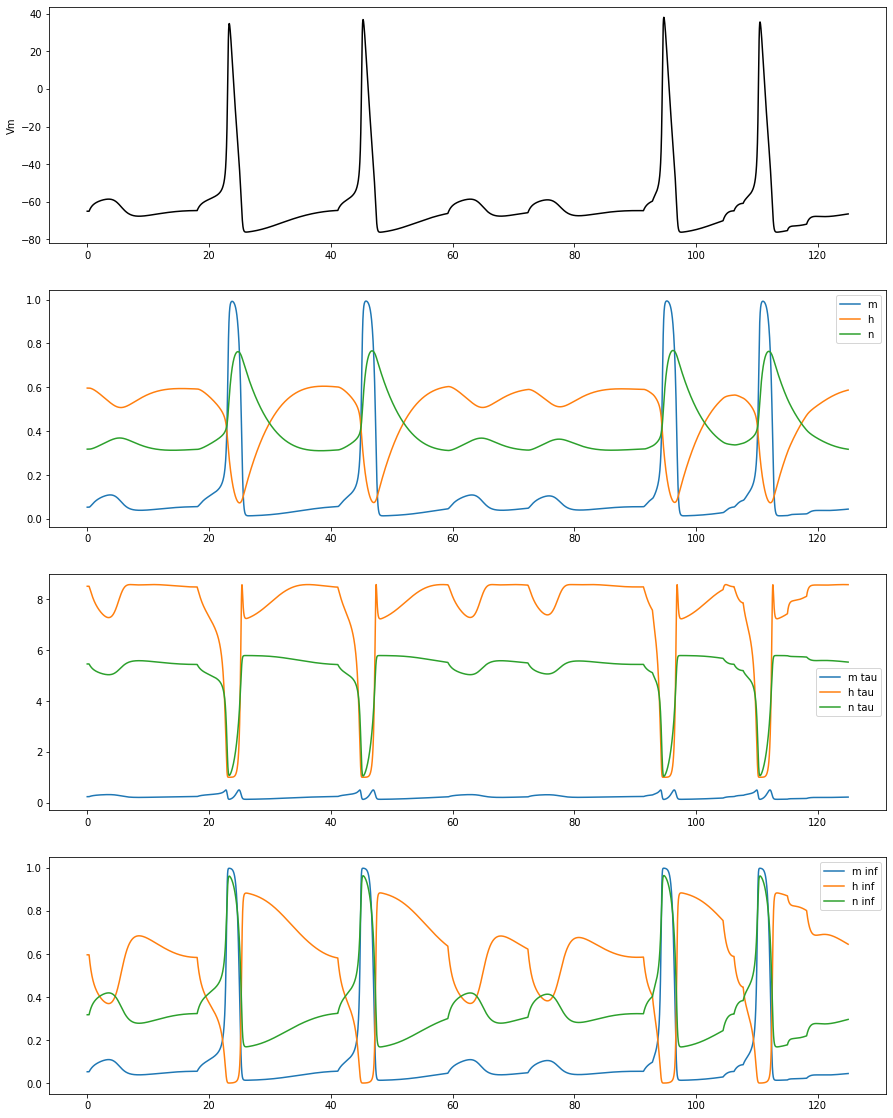

In [60]:
fig, axes = plt.subplots(4,1, figsize = (15,20))

t0 = 0
nframes = 5000

axes[0].plot(sim_df[0, 0:nframes], sim_df[1, 0:nframes], color = 'black')
axes[0].set_ylabel('Vm')

axes[1].plot(sim_df[0, 0:nframes], sim_df[2, 0:nframes])
axes[1].plot(sim_df[0, 0:nframes], sim_df[3, 0:nframes])
axes[1].plot(sim_df[0, 0:nframes], sim_df[4, 0:nframes])
axes[1].legend(['m','h','n'])

axes[2].plot(sim_df[0, 0:nframes], taus[0, 0:nframes])
axes[2].plot(sim_df[0, 0:nframes], taus[1, 0:nframes])
axes[2].plot(sim_df[0, 0:nframes], taus[2, 0:nframes])
axes[2].legend(['m tau','h tau','n tau'])

axes[3].plot(sim_df[0, 0:nframes], infs[0, 0:nframes])
axes[3].plot(sim_df[0, 0:nframes], infs[1, 0:nframes])
axes[3].plot(sim_df[0, 0:nframes], infs[2, 0:nframes])
axes[3].legend(['m inf','h inf','n inf'])

plt.show()